In [1]:
1 + 1

2

In [9]:
import pynbody as pnb
import pynbody.plot.sph as sph

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LogNorm
import scipy.stats as ss
from pytreegrav import Potential, PotentialTarget

def load_snapshot0(sim_name, z = -1): #load z=0 snapshot
    if sim_name == 'Romulus25':
        simdir = '/project/rrg-babul-ad/rennehan/romulus_data/cosmo25/'
        param_file = simdir+'cosmo25p.768sg1bwK1BHe75_v4.param'

        ## load snapshot numbers
        filelist = os.listdir(simdir)
        result = [i[-6:] for i in filelist if i.startswith('cosmo25p.') and len(i)==31]
        result.sort()
        result = result[4:]
        snap = result[z] # snapshot id of z=0 snapshot (i.e. the most recent snapshot)
        data_file = simdir+'cosmo25p.768sg1bwK1BHe75.'+snap
        
    elif sim_name == 'RomulusC':
        simdir = '/project/rrg-babul-ad/rennehan/romulus_data/h1.cosmo50/'
        param_file = '/project/rrg-babul-ad/rennehan/romulus_data/h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.param'

        filelist = os.listdir(simdir)
        result = [i[-6:] for i in filelist if i.startswith('h1.cosmo50') and len(i)==35]
        result.sort()
        snap = result[-1]
        data_file = simdir+'h1.cosmo50PLK.1536gst1bwK1BH.'+snap

    elif sim_name == 'RomulusG1':
        simdir = '/project/rrg-babul-ad/rennehan/romulus_data/h102054gs/'
        param_file = '/project/rrg-babul-ad/rennehan/romulus_data/h102054gs/h102054gs.param'

        filelist = os.listdir(simdir)
        result = [i[10:-10] for i in filelist if i.startswith('h102054gs.') and len(i)==26]
        result.sort()
        snap = result[-1]
        data_file = simdir+'h102054gs.'+snap
        
    elif sim_name == 'RomulusG2':
        simdir = '/project/rrg-babul-ad/rennehan/romulus_data/h82651gs/'
        param_file = '/project/rrg-babul-ad/rennehan/romulus_data/h82651gs/h82651gs.param'
        result = [i[9:-10] for i in filelist if i.endswith('amiga.grp') and len(i)==25]
        result.sort()
        snap = result[-1]
        data_file = simdir+'h82651gs.'+snap

    s = pnb.load(data_file, paramfile = param_file)
    s.physical_units()
    return(s)

s = load_snapshot0('Romulus25')
h = s.halos(ahf_mpi = True) #load halo catalogue
len(h) # There are a LOT of halos at z=0. You'll need to decide what kind of sample you want. (e.g., mass, host halo, etc)

#haloid = 65502
#haloid = 99966
## Haloids of 19 most massive halos in ROMULUS
halolist = np.array([39963.0, 49047.0, 67526.0, 89615.0, 52024.0, 79654.0, 99966.0, 49510.0, 27666.0, 42778.0, 14620.0, 97045.0, 61270.0, 77876.0, 65502.0, 18714.0, 91655.0, 82151.0, 38182.0], dtype = int)

## Haloids of Spheroidal halos in ROMULUS
#halolist = np.array([82151, 49510, 13455,     1, 30900, 87235, 98808])

#haloid = halolist[1]
haloid = 52024
h0 = h[haloid]

## Determine the center of mass of the given particles, then recenter accordingly
pnb.analysis.halo.center(h0, mode='pot', move_all = True, vel = True)
com = pnb.analysis.halo.center_of_mass(h0)
vcom = pnb.analysis.halo.center_of_mass_velocity(h0)

#calculate and find the R500 and M500
import XIGrM.calculate_R as cR
import XIGrM.cosmology as cos
prop = s.properties
virovdens = cos.Delta_vir(s)
rdict = {'vir': virovdens,'200': 200, '500': 500, '2500': 2500}
center = com
#dic
MassRadii = cR.get_radius(h0, overdensities=list(rdict.values()), rho_crit=None, prop=prop, precision=1e-2, cen=center, rmax=None)
print(MassRadii)
Rvir = MassRadii[1][virovdens]
s_filt = h0[pnb.filt.Sphere(55)]
width = 55
## You can rotate the halo to get a face-on or edge-on view of the central galaxy
pnb.analysis.angmom.sideon(s_filt.star, disksize = '5 kpc', move_all = False, cen = [0,0,0], vcen = [0,0,0])
no_disk = h0.star[~pnb.filt.Cuboid(x1 = -width/2, y1 = -3, z1 = -Rvir, x2 = width/2, y2 = 3, z2 = Rvir)]
no_disk = no_disk.star[no_disk.star['grp'] == haloid]
primary_halo = h0.star[h0.star['grp'] == haloid]

({102.9: SimArray(2.5573547e+12, dtype=float32, 'Msol'), 200.0: SimArray(2.2467185e+12, dtype=float32, 'Msol'), 500.0: SimArray(1.8591739e+12, dtype=float32, 'Msol'), 2500.0: SimArray(1.2172176e+12, dtype=float32, 'Msol')}, {102.9: SimArray(359.74325361, 'kpc'), 200.0: SimArray(276.32508637, 'kpc'), 500.0: SimArray(191.2783615, 'kpc'), 2500.0: SimArray(97.11168792, 'kpc')})


Freedman–Diaconis number of bins: 637


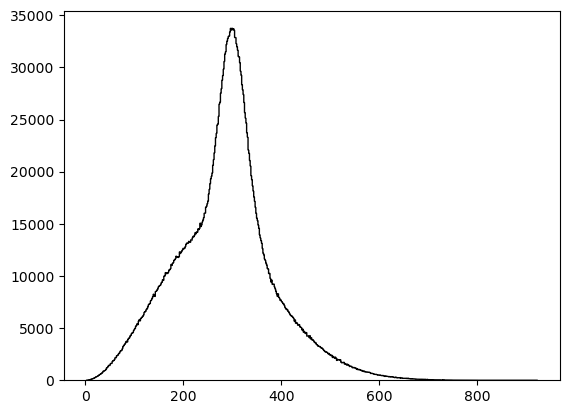

In [10]:
v2 = primary_halo.star['v2']
v = np.sqrt(v2)

q25, q75 = np.percentile(v, [25, 75])
bin_width = 2 * (q75 - q25) * len(v) ** (-1/3)
bins = round((v.max() - v.min()) / bin_width)
print("Freedman–Diaconis number of bins:", bins)

n_bins = int(bins)
hist, bin_edges = np.histogram(v, bins = n_bins)
v_med = []
for i in range(n_bins):
    v_med.append(np.mean(bin_edges[i: i+2]))

v_med = np.array(v_med)
hist = np.array(hist)
x = plt.hist(v, bins = n_bins, histtype = 'step', color = 'black', label = 'Romulus data')

In [4]:
r0 = 0.5 # in kpc
r_arr = 10**np.linspace(np.log10(r0), np.log10(Rvir), 100)

In [5]:
mass = []
for i in range(100):
    current_region = primary_halo[pnb.filt.Sphere(r_arr[i])]
    mass.append(current_region.star['mass'].sum())

np.savetxt(f'mass_bins_{haloid}.txt', mass, delimiter = ' ')

In [6]:
mass = np.loadtxt(f'mass_bins_{haloid}.txt', delimiter = ' ')

half_mass = mass[-1]/2

m_arr = abs(mass - half_mass)
r_eff = r_arr[np.where(m_arr == min(m_arr))[0]]
r_eff

SimArray([16.92338298])

In [7]:
from scipy.optimize import fsolve, curve_fit
order = 0.5
from scipy.special import iv

def New_maxwell(vel, v0, sigma, k):
    vel = vel/sigma
    Lambda = v0**2/sigma**2
    mod_bessel = iv(order, np.sqrt(Lambda*vel**2))
    non_central_chi_sq =  (0.5 * np.exp( -(vel**2 + Lambda)/2 ) * (vel**2/Lambda)**(3/4 - 1/2) ) * mod_bessel * 2 * vel
    return k * non_central_chi_sq

def double_new_maxwell(vel, v0, sigma0, k0, v1, sigma1, k1):
    return New_maxwell(vel, v0, sigma0, k0) + New_maxwell(vel, v1, sigma1, k1)

def triple_maxwell(vel, v0, sigma0, k0, v1, sigma1, k1, v2, sigma2, k2):
    return New_maxwell(vel, v0, sigma0, k0) + New_maxwell(vel, v1, sigma1, k1) + New_maxwell(vel, v2, sigma2, k2)

def Maxwell(v, sigma, k):
    return k * v**2 * np.exp(-v**2/sigma**2) / sigma**(3/2)

def double_maxwell(v, sigma, k, sigma1, k1):
    return Maxwell(v, sigma, k) + Maxwell(v, sigma1, k1)

def Triple_maxwell(v, sigma, k, v01, sigma1, k1, sigma2, k2):
    return Maxwell(v, sigma, k) + New_maxwell(v, v01, sigma1, k1) + Maxwell(v, sigma2, k2)

def triple_maxwell(v, sigma, k, sigma1, k1, sigma2, k2):
    return Maxwell(v, sigma, k) + Maxwell(v, sigma1, k1) + Maxwell(v, sigma2, k2)

array([  50.        ,  100.        ,  148.78291667,   94.05492013,
       1000.        ,  205.26115375, 1377.61415698])

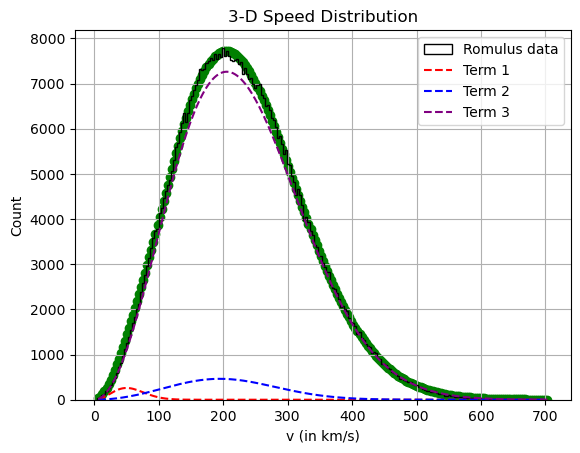

In [8]:
opt, cov = curve_fit(Triple_maxwell, v_med, hist, p0 = [100, 10**5, 50, 250, 10**4, 300, 10**4], bounds = [[50, 10**2, 1, 50, 10**3, 100, 10**2], [200, 10**7, 450, 250, 10**6, 400, 10**6]])
#opt, cov = curve_fit(double_new_maxwell, v_med, hist, p0 = [350, 80, 10**5, 1, 200, 15000], bounds = ([200, 10, 10**2, 0, 0, 100], [450, 450, 180000, 250, 300, np.inf]))
f_v = []
term1 = []
term2 = []
term3 = []
for x in v_med:
    f_v.append(Triple_maxwell(x, *opt))
    term1.append(Maxwell(x, *opt[:2]))
    term2.append(New_maxwell(x, *opt[2:5]))
    term3.append(Maxwell(x, *opt[5:]))

plt.hist(v, bins = n_bins, histtype = 'step', color = 'black', label = 'Romulus data')
plt.scatter(v_med, f_v, color = 'green')
plt.plot(v_med, term1, color = 'red', linestyle = 'dashed', label = 'Term 1')
plt.plot(v_med, term2, color = 'blue', linestyle = 'dashed', label = 'Term 2')
plt.plot(v_med, term3, color = 'purple', linestyle = 'dashed', label = 'Term 3')
plt.legend()
plt.grid()
plt.title('3-D Speed Distribution')
plt.xlabel('v (in km/s)')
plt.ylabel('Count')
opt

/home/guru2k2/anaconda3/envs/new_env3/lib/python3.7/site-packages/pynbody/array.py:865: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.base[self._reexpress_index(item)]


Freedman–Diaconis number of bins: 430.0


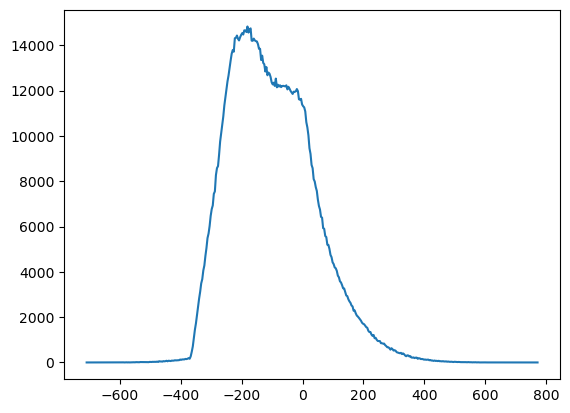

In [12]:
v_LOS_edge = no_disk['vel'][:, 2]
q25, q75 = np.percentile(v_LOS_edge, [25, 75])
bin_width = 2 * (q75 - q25) * len(v_LOS_edge) ** (-1/3)
bins = np.round((v_LOS_edge.max() - v_LOS_edge.min()) / bin_width)
print("Freedman–Diaconis number of bins:", bins)

n_bins = int(bins)
hist2, bin_edges = np.histogram(v_LOS_edge, bins = n_bins)
v_med2 = []
for i in range(n_bins):
    v_med2.append(np.mean(bin_edges[i: i+2]))

v_med2 = np.array(v_med2)
hist2 = np.array(hist2)
plt.plot(v_med2, hist2)

In [9]:
def Gaussian(x, mu, sigma, k1):
    return k1 * np.exp(-(x - mu)**2 / (2*sigma**2)) / (sigma * np.sqrt(2*np.pi))

def double_Gaussian(x, mu1, sigma1, k1, mu2, sigma2, k2):
    return Gaussian(x, mu1, sigma1, k1) + Gaussian(x, mu2, sigma2, k2)

array([1.33466416e+00, 9.32347743e-04, 1.24459033e+02])

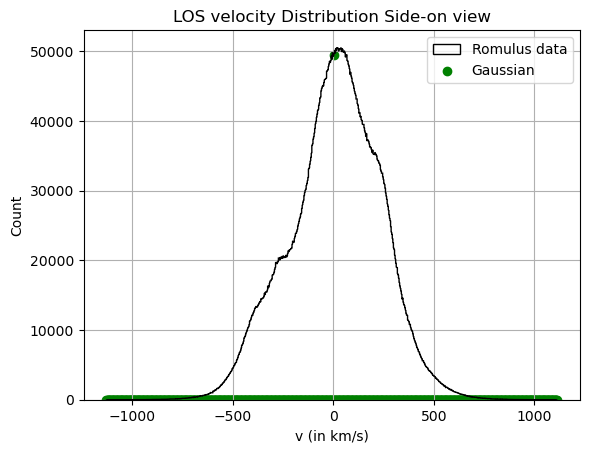

In [10]:
opt, cov = curve_fit(Gaussian, v_med2, hist2)
f_v = []
term1 = []
term2 = []
for x in v_med2:
    f_v.append(Gaussian(x, *opt))
    #term1.append(Gaussian(x, *opt[:3]))
    #term2.append(Gaussian(x, *opt[3:]))

plt.hist(v_LOS_edge, bins = n_bins, histtype = 'step', color = 'black', label = 'Romulus data')
plt.scatter(v_med2, f_v, color = 'green', label = 'Gaussian')
#plt.plot(v_med2, term1, color = 'red', linestyle = 'dashed', label = 'Term 1')
#plt.plot(v_med2, term2, color = 'blue', linestyle = 'dashed', label = 'Term 2')
plt.legend()
plt.grid()
plt.title('LOS velocity Distribution Side-on view')
plt.xlabel('v (in km/s)')
plt.ylabel('Count')
opt

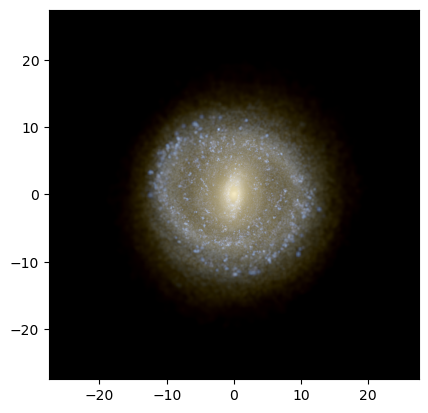

In [13]:
## You can rotate the halo to get a face-on or edge-on view of the central galaxy
pnb.analysis.angmom.faceon(s_filt.star, disksize = '5 kpc', move_all = False, cen = [0,0,0], vcen = [0,0,0])
rgb = pnb.plot.stars.render(s_filt.star[np.isnan(s_filt.star['r_lum_den'])==False], width = width, resolution = 1000, mag_range = [17,26],plot = False,ret_im = True)
plt.imshow(rgb[::-1,:],extent=(-width / 2, width / 2, -width / 2, width / 2))

Freedman–Diaconis number of bins: 1035.0


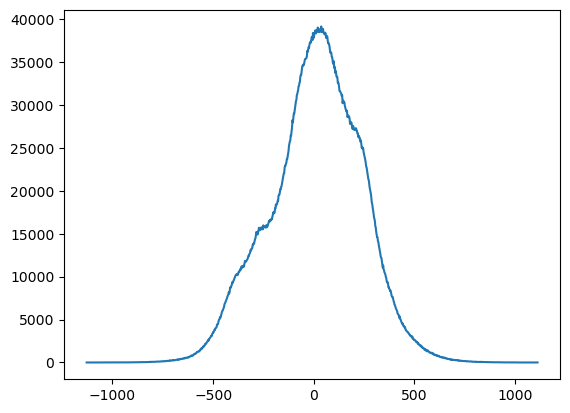

In [12]:
v_LOS_face = no_disk['vel'][:, 2]
q25, q75 = np.percentile(v_LOS_face, [25, 75])
bin_width = 2 * (q75 - q25) * len(v_LOS_edge) ** (-1/3)
bins = np.round((v_LOS_face.max() - v_LOS_face.min()) / bin_width)
print("Freedman–Diaconis number of bins:", bins)

n_bins = int(bins)
hist2, bin_edges = np.histogram(v_LOS_edge, bins = n_bins)
v_med2 = []
for i in range(n_bins):
    v_med2.append(np.mean(bin_edges[i: i+2]))

v_med2 = np.array(v_med2)
hist2 = np.array(hist2)
plt.plot(v_med2, hist2)
plt.show()

array([2.91440852e+01, 2.19055646e+02, 1.99535361e+07])

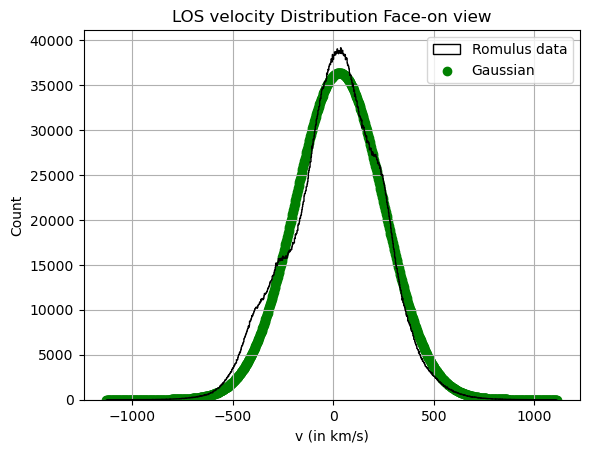

In [13]:
opt, cov = curve_fit(Gaussian, v_med2, hist2, p0 = [0, 200, 10**6])
f_v = []
term1 = []
term2 = []
for x in v_med2:
    f_v.append(Gaussian(x, *opt))
    #term1.append(Gaussian(x, *opt[:3]))
    #term2.append(Gaussian(x, *opt[3:]))

plt.hist(v_LOS_edge, bins = n_bins, histtype = 'step', color = 'black', label = 'Romulus data')
plt.scatter(v_med2, f_v, color = 'green', label = 'Gaussian')
#plt.plot(v_med2, term1, color = 'red', linestyle = 'dashed', label = 'Term 1')
#plt.plot(v_med2, term2, color = 'blue', linestyle = 'dashed', label = 'Term 2')
plt.legend()
plt.grid()
plt.title('LOS velocity Distribution Face-on view')
plt.xlabel('v (in km/s)')
plt.ylabel('Count')
opt

Removing disk stars using angular momentum

In [14]:
p_halo = h0.star[h0.star['grp'] == haloid]
pos = p_halo['pos']
vel = p_halo['vel']
J = np.cross(pos, vel)
J_z = J[:, 2]
J_tot = np.sqrt(np.sum(J**2, axis = 1))

ratio = J_z/J_tot
np.where(ratio == 0)[0]

/home/guru2k2/anaconda3/envs/new_env3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


array([], dtype=int64)

In [15]:
disk = p_halo[np.where(ratio >= 0.8)[0]]
other = p_halo[np.where(ratio < 0.8)[0]]

Freedman–Diaconis number of bins: 554


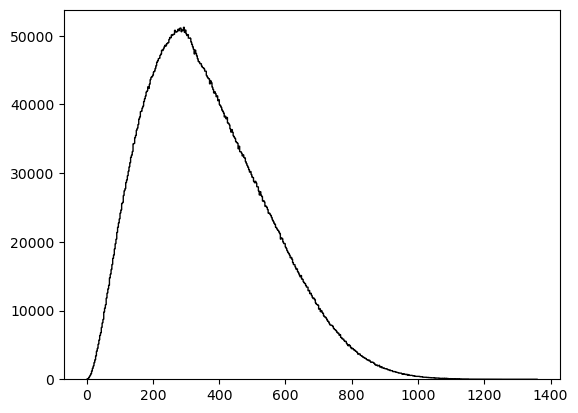

In [16]:
v2 = other.star['v2']
v = np.sqrt(v2)

q25, q75 = np.percentile(v, [25, 75])
bin_width = 2 * (q75 - q25) * len(v) ** (-1/3)
bins = round((v.max() - v.min()) / bin_width)
print("Freedman–Diaconis number of bins:", bins)

n_bins = int(bins)
hist, bin_edges = np.histogram(v, bins = n_bins)
v_med = []
for i in range(n_bins):
    v_med.append(np.mean(bin_edges[i: i+2]))

v_med = np.array(v_med)
hist = np.array(hist)
x = plt.hist(v, bins = n_bins, histtype = 'step', color = 'black', label = 'Romulus data')

array([2.26461838e+00, 1.73318892e+02, 2.89862253e+04])

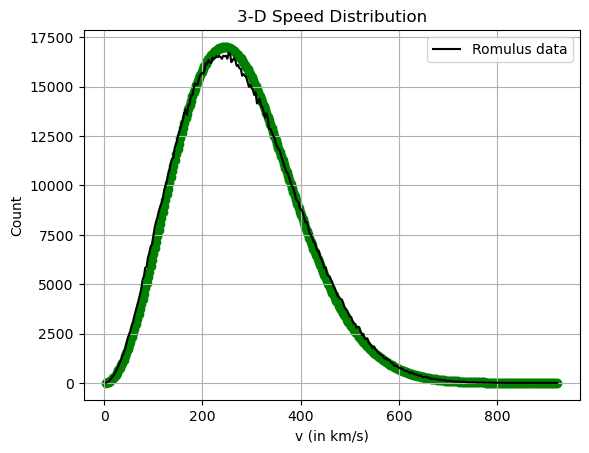

In [31]:
#opt, cov = curve_fit(New_maxwell, v_med, hist)
opt, cov = curve_fit(New_maxwell, v_med, hist, p0 = [350, 80, 10**5], bounds = ([2, 10, 10**2], [450, 450, 180000]))
f_v = []
term1 = []
term2 = []
for x in v_med:
    f_v.append(New_maxwell(x, *opt))
    #term1.append(New_maxwell(x, *opt[:3]))
    #term2.append(New_maxwell(x, *opt[3:]))

plt.plot(v_med, hist, color = 'black', label = 'Romulus data')
plt.scatter(v_med, f_v, color = 'green')
#plt.plot(v_med, term1, color = 'red', linestyle = 'dashed', label = 'Term 1')
#plt.plot(v_med, term2, color = 'blue', linestyle = 'dashed', label = 'Term 2')
plt.legend()
plt.grid()
plt.title('3-D Speed Distribution')
plt.xlabel('v (in km/s)')
plt.ylabel('Count')
opt

Freedman–Diaconis number of bins: 439.0


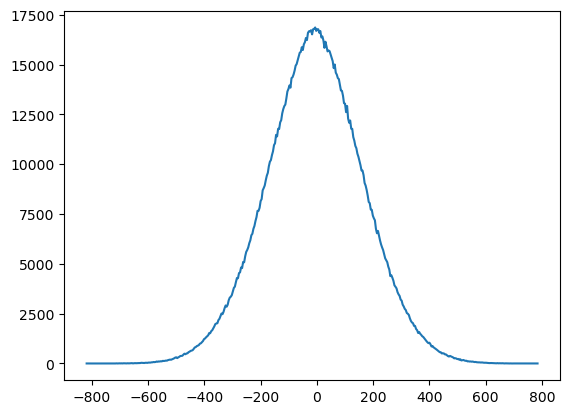

In [56]:
v_LOS_edge = other['vel'][:, 0]
q25, q75 = np.percentile(v_LOS_edge, [25, 75])
bin_width = 2 * (q75 - q25) * len(v_LOS_edge) ** (-1/3)
bins = np.round((v_LOS_edge.max() - v_LOS_edge.min()) / bin_width)
print("Freedman–Diaconis number of bins:", bins)

n_bins = int(bins)
hist2, bin_edges = np.histogram(v_LOS_edge, bins = n_bins)
v_med2 = []
for i in range(n_bins):
    v_med2.append(np.mean(bin_edges[i: i+2]))

v_med2 = np.array(v_med2)
hist2 = np.array(hist2)
plt.plot(v_med2, hist2)

array([-6.83537336e+00,  1.66701090e+02,  6.80290234e+06])

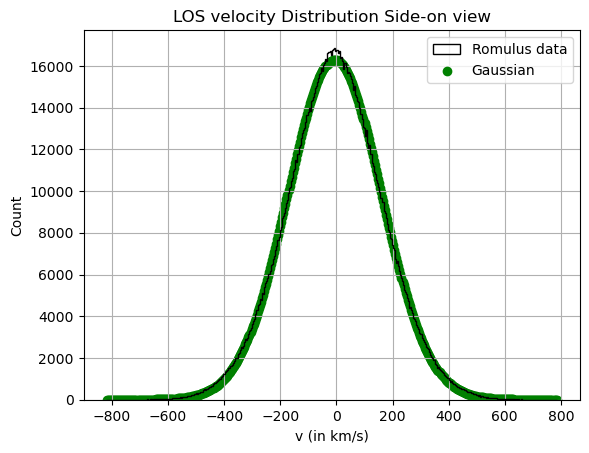

In [59]:
opt, cov = curve_fit(Gaussian, v_med2, hist2, p0 = [0, 150, 10**5])
f_v = []
term1 = []
term2 = []
for x in v_med2:
    f_v.append(Gaussian(x, *opt))
    #term1.append(Gaussian(x, *opt[:3]))
    #term2.append(Gaussian(x, *opt[3:]))

plt.hist(v_LOS_edge, bins = n_bins, histtype = 'step', color = 'black', label = 'Romulus data')
plt.scatter(v_med2, f_v, color = 'green', label = 'Gaussian')
#plt.plot(v_med2, term1, color = 'red', linestyle = 'dashed', label = 'Term 1')
#plt.plot(v_med2, term2, color = 'blue', linestyle = 'dashed', label = 'Term 2')
plt.legend()
plt.grid()
plt.title('LOS velocity Distribution Side-on view')
plt.xlabel('v (in km/s)')
plt.ylabel('Count')
opt

In [52]:
len(v_LOS_edge)

1872923

In [53]:
len(v)

1872923